In [20]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os

import myfitnesspal
import browser_cookie3
import datetime
from datetime import timedelta

pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 20)

In [21]:
current_path = os.path.abspath("")
directory = os.path.dirname(current_path)
results_directory = rf"{directory}\bormhub_results"

In [22]:
client = myfitnesspal.Client(cookiejar = browser_cookie3.firefox())
client.get_date(2025,1,20)

<01/20/25 {'calories': 3456.0, 'carbohydrates': 370.0, 'fat': 129.0, 'protein': 175.0, 'sodium': 4031.0, 'sugar': 98.0}>

In [23]:
days_back = 80
start_date = datetime.date.today() - timedelta(days=days_back)

cals = client.get_report("Calories", "nutrition", start_date)
net_cals = client.get_report("Net Calories", "nutrition", start_date)

In [24]:
cals_df = pd.DataFrame(cals.values(), index=cals.keys(), columns=['cals'])
net_cals_df = pd.DataFrame(net_cals.values(), index=net_cals.keys(), columns=['net_cals'])

df = pd.concat([cals_df, net_cals_df], axis=1).fillna(0)
def datetime_to_pd_timestamp(datetime): return pd.Timestamp(datetime) 
df.index = df.index.map(datetime_to_pd_timestamp)
df

,cals,net_cals
2024-11-11,0,0
2024-11-12,0,-367
2024-11-13,0,0
2024-11-14,3030,3030
2024-11-15,3651,3406
2024-11-16,2996,2996
2024-11-17,2908,2908
2024-11-18,3256,2949
2024-11-19,2668,2668
2024-11-20,2861,2861


In [25]:
# split into empty and non-empty
df_empty = df[df['cals'] == 0]
df = df[df['cals'] != 0]

In [26]:
# import weight data
weight_md_path = rf"{directory}\Notes\Fitness\Body weight.md" 
weight_df = pd.read_csv(weight_md_path, sep=",", header=None)

weight_df[0] = pd.to_datetime(weight_df[0], format="%Y-%m-%d")

weight_df[1] = pd.to_numeric(weight_df[1], errors='coerce')
weight_df = weight_df.rename(columns={0: "date", 1: 'weight'})
weight_df = weight_df.set_index('date')
weight_df

,weight
date,
2025-01-28,81.7
2025-01-27,81.9
2025-01-26,81.9
2025-01-25,82.7
2025-01-24,81.9
2025-01-23,82.6
2025-01-22,81.1
2025-01-21,82.0
2025-01-20,82.4


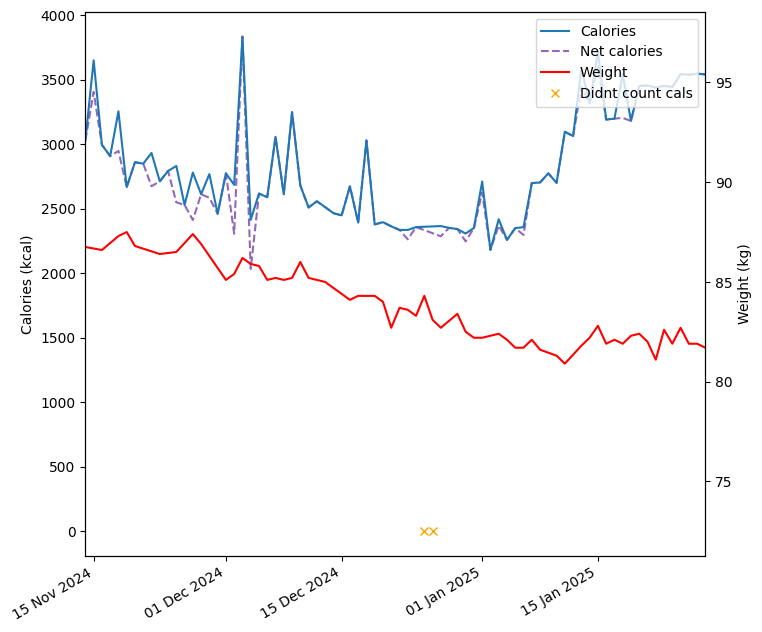

In [27]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ln2 = ax1.plot(df.index,df['net_cals'], linestyle='--', color='tab:purple', label='Net calories')
ln1 = ax1.plot(df.index,df['cals'], label='Calories')
ln3 = ax2.plot(weight_df.index,weight_df['weight'], 'r', label='Weight')
ln4 = ax1.plot(df_empty.index,df_empty['cals'], 'x', color='orange', label='Didnt count cals')

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)

ax1.set_xlim([min(df.index), max(weight_df.index)])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
plt.gcf().autofmt_xdate()

ax1.set_ylabel("Calories (kcal)")
ax2.set_ylabel("Weight (kg)")

plt.savefig(rf'{results_directory}\figures\cals.png', dpi=300, bbox_inches='tight')

In [28]:
# combine calories df and weight df
results = pd.concat([df, weight_df], axis=1)
# crop initial rows before we get calorie data
results = results.loc[results['cals'].first_valid_index():]
# results

In [29]:
# estimate of caloric deficit for 1 kg fat
# https://www.reddit.com/r/loseit/comments/yux3os/1_kg_7000_or_7700_calories/
kcal_per_kg = 7740
print(f"To gain 1 kg/month, eat at {kcal_per_kg/30.43:.1f} kcal surplus")

To gain 1 kg/month, eat at 254.4 kcal surplus


In [30]:
weight_diff_list = pd.Series(name = 'weight_change')
cal_intake_list = pd.Series(name = 'cal_daily_intake')
cal_maintenance_list = pd.Series(name = 'cal_maintenance')
for index, row in results.iterrows():
    weight = row['weight']
    if not np.isnan(weight):
        # find next valid weight
        rest_of_results = results.loc[index:]
        # crop the first row from rest of results
        rest_of_results = rest_of_results.iloc[1:]
        next_weight_index = rest_of_results['weight'].first_valid_index()
        # have to check for none in case this is the final row
        if next_weight_index != None:
            next_weight = results.loc[next_weight_index, 'weight']
            weight_change = (next_weight - weight)
            # add weight_change to our dataframe
            weight_diff_list.loc[index] = weight_change
            # find all calories intaken from between now to the next valid weight
            interim_calories = results['net_cals'].loc[index:next_weight_index]

            days_to_next = len(interim_calories) - 1
            # need to do a check if i missed calorie counting on any of the days to next weight index, and if so skip the rest
            if (next_weight_index - index).days == days_to_next:
                # get rid of last row of interim_calories
                interim_calories = interim_calories.head(days_to_next)
                cal_intake = sum(interim_calories)
                cal_daily_intake = cal_intake / days_to_next
                # add cal_daily_intake to our dataframe
                cal_intake_list.loc[index] = cal_daily_intake
                cal_daily_surplus = weight_change * kcal_per_kg / days_to_next
                # add estimated cal_maintenance to our dataframe
                cal_maintenance_list.loc[index] = cal_daily_intake - cal_daily_surplus

results = pd.concat([results, weight_diff_list, cal_intake_list, cal_maintenance_list], axis=1)
display(results)

,cals,net_cals,weight,weight_change,cal_daily_intake,cal_maintenance
2024-11-14,3030.0,3030.0,NaN,NaN,NaN,NaN
2024-11-15,3651.0,3406.0,NaN,NaN,NaN,NaN
2024-11-16,2996.0,2996.0,86.6,0.7,2952.000000,243.000000
2024-11-17,2908.0,2908.0,NaN,NaN,NaN,NaN
2024-11-18,3256.0,2949.0,87.3,0.2,2949.000000,1401.000000
2024-11-19,2668.0,2668.0,87.5,-0.7,2668.000000,8086.000000
2024-11-20,2861.0,2861.0,86.8,-0.4,2795.333333,3827.333333
2024-11-21,2850.0,2850.0,NaN,NaN,NaN,NaN
2024-11-22,2933.0,2675.0,NaN,NaN,NaN,NaN
2024-11-23,2713.0,2713.0,86.4,0.1,2753.000000,2366.000000


2024-11-16    3037.619048
2024-11-18    3565.041667
2024-11-19    3972.148148
2024-11-20    4285.433333
2024-11-23    3937.030303
2024-11-25    3285.111111
2024-11-27    3506.025641
2024-11-28    3456.166667
2024-11-29    4012.809524
2024-11-30    4042.452381
                 ...     
2025-01-18    2772.821429
2025-01-19    3054.250000
2025-01-20    3335.785714
2025-01-21    3674.857143
2025-01-22    4059.615385
2025-01-23    3517.000000
2025-01-24    3687.272727
2025-01-25    3581.300000
2025-01-26    3967.111111
2025-01-27    4162.125000
Name: cal_maintenance, Length: 61, dtype: float64

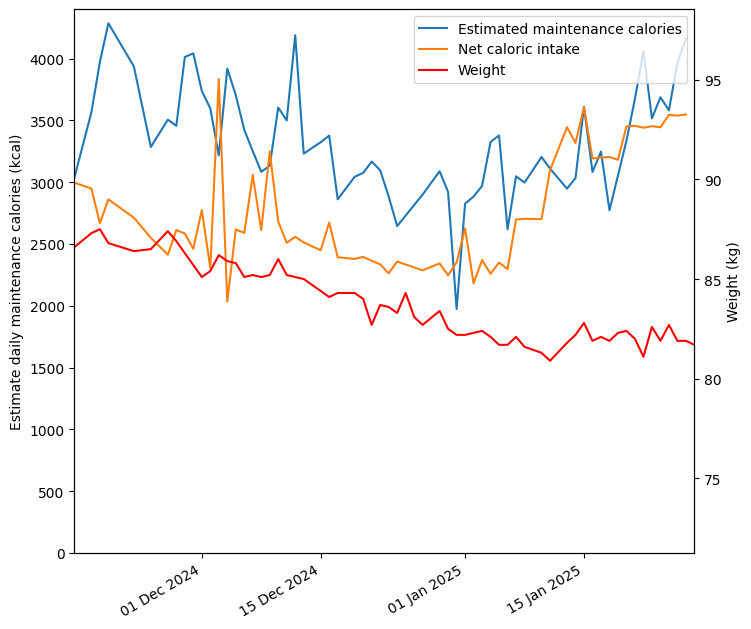

In [31]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

results_clean = results.dropna()
rolling_mean_window = 14
rolling_mean_maintenance = results_clean['cal_maintenance'].rolling(window=rolling_mean_window, center=True, min_periods=1).mean()
ln1 = ax1.plot(results_clean.index, rolling_mean_maintenance, label='Estimated maintenance calories')
ln2 = ax1.plot(results_clean.index,results_clean['net_cals'], label='Net caloric intake')
ln3 = ax2.plot(weight_df.index,weight_df['weight'], 'r', label='Weight')

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)

ax1.set_xlim([min(results_clean.index), max(weight_df.index)])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
plt.gcf().autofmt_xdate()

ax1.set_ylabel("Estimate daily maintenance calories (kcal)")
ax2.set_ylabel("Weight (kg)")

ax1.axis([None,None,0,None])

display(rolling_mean_maintenance)
estimated_maintenance = rolling_mean_maintenance.iloc[-1]

plt.savefig(rf'{results_directory}\figures\maintenance.png', dpi=300, bbox_inches='tight')

In [32]:
print(f"To gain 1 kg/month, need to have {kcal_per_kg} kcal surplus in that month")
print(f"Need {kcal_per_kg/30.43:.1f} kcal surplus per day")
print(f"{estimated_maintenance:.1f} kcal is estimated current maintenance")
print(f"{estimated_maintenance + (kcal_per_kg / 30.43):.1f} kcal is estimated bulk")

To gain 1 kg/month, need to have 7740 kcal surplus in that month
Need 254.4 kcal surplus per day
4162.1 kcal is estimated current maintenance
4416.5 kcal is estimated bulk
